# Fine-tuning 2nd. Workflow
1. 하이브리드 라벨링 전략 (Hybrid Labeling Strategy)
    - 1단계 (우선순위): Auto-Labeling (YOLOv8x)
        - 일단 Pre-trained 모델로 "차량 전체 형상"을 찾기
        - 성공 시: Normal 데이터와 기준이 같아지므로 베스트
    - 2단계 (Fallback): JSON 라벨 활용
        - 만약 모델이 너무 확대된(Zoom-in) 이미지라 차량을 못 찾으면(Empty), 그때 JSON의 파손 부위 좌표를 가져옴
    - 이유: "못 찾았다고 빈 파일(Background)"로 두면 안 됩니다. Damaged 폴더에 있으므로 무조건. 부분만이라도 '차량'이라고 가르쳐야

2. 데이터 분할 및 격리
 - 모델의 암기(Memorizing)를 방지하고 객관적인 성능 검증을 위한 데이터 분리.
 - 비율 (Ratio): 전체 데이터를 7 : 2 : 1 비율로 랜덤 분할.
    - Train (70%): 모델 가중치 업데이트용 (학습).
    - Val (20%): 학습 중 성능 모니터링 및 조기 종료(Early Stopping) 결정용.
    - Test (10%): 완전 격리(Isolation). 학습 과정에 절대 관여하지 않으며, 최종 성능 평가에만 사용.

3. 학습 환경 설정 (Configuration)
 - YOLO 모델이 데이터셋의 위치와 클래스 정보를 알 수 있도록 설정.
 - yolov8_tuning_251207.yaml 생성: Train/Val 경로 및 클래스명(Vehicle) 정의 (Test 경로 제외)
 - Hyperparameter:
    - Freeze: Pre-trained 가중치 앞단을 고정하여 기존의 일반적인 특징 추출 능력 유지.
    - Epochs: 15~20회 (과적합 방지를 위해 적절한 횟수 설정).
    - Learning Rate: 미세 조정을 위해 낮은 학습률 적용.

4. 학습 수행 (Fine-tuning Execution)
 - 준비된 데이터(Train/Val)를 통해 모델이 새로운 도메인(파손, 줌인 이미지) 적응.
 - process
    - Pre-trained yolov8x.pt 로드.
    - 손실 함수(Loss Function)가 최소화되는 방향으로 가중치 업데이트.
    - 결과물: 우리 데이터에 최적화된 best.pt 모델 생성

 5. 최종 성능 평가 (Final Evaluation)
 - 학습에 사용되지 않은 Test Set을 사용하여 실전 성능 검증.
 - 검증 방법
    - 격리해둔 Test Set(10%)에 대해 추론 수행.
    - 기존 Pre-trained 모델 대비 False Negative(미검출) 감소량 확인.
    - 주요 지표: Accuracy(정확도), Recall(재현율), Confusion Matrix(혼동 행렬) 비교 분석.

# 1. 라이브러리 설치

In [1]:
# [Cell 1] 라이브러리 설치
# YOLOv8 및 데이터 처리에 필요한 라이브러리 설치
!pip install ultralytics tqdm

import os
import shutil
import json
import random
import yaml
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from ultralytics import YOLO
from tqdm import tqdm
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from google.colab import drive

# 구글 드라이브 마운트
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

print("✅ 환경 설정 완료")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 10.0 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Mounted at /content/drive
✅ 환경 설정 완료


# 2. 데이터셋 구축 및 분할

In [ ]:
# [Cell 2] 데이터셋 구축 (파일명 변경: data_hybrid.yaml)
import os
import shutil
import json
import random
from ultralytics import YOLO
from tqdm import tqdm

# =========================================================
# [설정] 경로
# =========================================================
SOURCE_ROOT = "/content/drive/MyDrive/03. HDMF/(share)2026_ImageDetectionStudy_No_resizing"
DATASET_ROOT = "/content/drive/MyDrive/03. HDMF/(pre_study)2026_ImageDetectionStudy/1_car_classification/(dataset)2026_FineTuning_Hybrid_Split_721"


# [수정됨] YAML 파일명을 명확하게 지정
YAML_FILENAME = "data_hybrid.yaml"

# 오토 라벨링용 모델
auto_label_model = YOLO('yolov8x.pt')
TARGET_CLASSES = [2, 5, 7] # Car, Bus, Truck

def convert_bbox_to_yolo(size, box):
    dw = 1. / size[0]
    dh = 1. / size[1]
    x_center = (box[0] + box[2] / 2.0) * dw
    y_center = (box[1] + box[3] / 2.0) * dh
    w = box[2] * dw
    h = box[3] * dh
    return (x_center, y_center, w, h)

def build_new_dataset_version():
    if os.path.exists(DATASET_ROOT):
        print(f"♻️ 기존 폴더 초기화 중... ({os.path.basename(DATASET_ROOT)})")
        shutil.rmtree(DATASET_ROOT)

    for split in ['train', 'val', 'test']:
        os.makedirs(os.path.join(DATASET_ROOT, 'images', split), exist_ok=True)
        os.makedirs(os.path.join(DATASET_ROOT, 'labels', split), exist_ok=True)

    print(f"🚀 새 데이터셋 구축 시작: {DATASET_ROOT}")

    strategies = {
        "damaged": "hybrid",
        "normal": "auto_label",
        "background": "empty"
    }

    total_count = 0
    split_counts = {'train': 0, 'val': 0, 'test': 0}

    for folder_name, strategy in strategies.items():
        img_dir = os.path.join(SOURCE_ROOT, folder_name, "images")
        label_dir = os.path.join(SOURCE_ROOT, folder_name, "labels")

        if not os.path.exists(img_dir): continue

        files = [f for f in os.listdir(img_dir) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]
        random.shuffle(files)

        n_files = len(files)
        n_train = int(n_files * 0.70)
        n_val = int(n_files * 0.90)

        print(f"Processing [{folder_name}]: {len(files)}장 (Strategy: {strategy})")

        for i, filename in enumerate(tqdm(files, desc=folder_name)):
            if i < n_train: split = 'train'
            elif i < n_val: split = 'val'
            else: split = 'test'

            split_counts[split] += 1

            src_img = os.path.join(img_dir, filename)
            dst_img = os.path.join(DATASET_ROOT, 'images', split, filename)
            dst_txt = os.path.join(DATASET_ROOT, 'labels', split, os.path.splitext(filename)[0] + ".txt")

            shutil.copy(src_img, dst_img)

            if strategy == "hybrid":
                results = auto_label_model(src_img, conf=0.1, verbose=False)
                found_boxes = []
                for result in results:
                    for box in result.boxes:
                        if int(box.cls[0]) in TARGET_CLASSES:
                            found_boxes.append(box.xywhn[0].tolist())

                if found_boxes:
                    with open(dst_txt, 'w') as out:
                        for bbox in found_boxes:
                            out.write(f"0 {bbox[0]:.6f} {bbox[1]:.6f} {bbox[2]:.6f} {bbox[3]:.6f}\n")
                else:
                    json_file = os.path.splitext(filename)[0] + ".json"
                    json_path = os.path.join(label_dir, json_file)
                    if os.path.exists(json_path):
                        with open(json_path, 'r') as f:
                            data = json.load(f)
                            w_img, h_img = data['images']['width'], data['images']['height']
                            with open(dst_txt, 'w') as out:
                                for ann in data['annotations']:
                                    yolo_box = convert_bbox_to_yolo((w_img, h_img), ann['bbox'])
                                    out.write(f"0 {yolo_box[0]:.6f} {yolo_box[1]:.6f} {yolo_box[2]:.6f} {yolo_box[3]:.6f}\n")

            elif strategy == "auto_label":
                results = auto_label_model(src_img, conf=0.25, verbose=False)
                with open(dst_txt, 'w') as out:
                    for result in results:
                        for box in result.boxes:
                            if int(box.cls[0]) in TARGET_CLASSES:
                                x, y, w, h = box.xywhn[0].tolist()
                                out.write(f"0 {x:.6f} {y:.6f} {w:.6f} {h:.6f}\n")

            elif strategy == "empty":
                with open(dst_txt, 'w') as out:
                    pass

            total_count += 1

    # 3. data_hybrid.yaml 생성
    yaml_content = f"""
path: {DATASET_ROOT}
train: images/train
val: images/val
names:
  0: Vehicle
"""
    # [수정됨] 파일명 변수 사용
    yaml_path = os.path.join(DATASET_ROOT, YAML_FILENAME)
    with open(yaml_path, 'w') as f:
        f.write(yaml_content)

    print("\n" + "="*50)
    print(f"✅ 데이터셋 구축 완료!")
    print(f"   📂 위치: {DATASET_ROOT}")
    print(f"   📄 설정 파일: {yaml_path}") # data_hybrid.yaml
    print("="*50)

build_new_dataset_version()

🚀 새 데이터셋 구축 시작: /content/drive/MyDrive/03. HDMF/(pre_study)2026_ImageDetectionStudy/1_car_classification/(dataset)2026_FineTuning_Hybrid_Split_721
Processing [damaged]: 1200장 (Strategy: hybrid)


damaged: 100%|██████████| 1200/1200 [07:46<00:00,  2.58it/s]


Processing [normal]: 157장 (Strategy: auto_label)


normal: 100%|██████████| 157/157 [00:29<00:00,  5.25it/s]


Processing [background]: 600장 (Strategy: empty)


background: 100%|██████████| 600/600 [00:17<00:00, 34.17it/s]


✅ 데이터셋 구축 완료!
   📂 위치: /content/drive/MyDrive/03. HDMF/(pre_study)2026_ImageDetectionStudy/1_car_classification/(dataset)2026_FineTuning_Hybrid_Split_721
   📄 설정 파일: /content/drive/MyDrive/03. HDMF/(pre_study)2026_ImageDetectionStudy/1_car_classification/(dataset)2026_FineTuning_Hybrid_Split_721/data_hybrid.yaml


In [2]:
# [Cell] 현재 데이터셋 분할 현황 확인
import os

# 1. 확인할 데이터셋 루트 경로
DATASET_ROOT = "/content/drive/MyDrive/03. HDMF/(pre_study)2026_ImageDetectionStudy/1_car_classification/(dataset)2026_FineTuning_Hybrid_Split_721"

def check_dataset_status():
    if not os.path.exists(DATASET_ROOT):
        print(f"❌ 데이터셋 폴더가 존재하지 않습니다: {DATASET_ROOT}")
        return

    splits = ['train', 'val', 'test']
    counts = {}

    # 각 폴더별 이미지 개수 카운트
    for split in splits:
        dir_path = os.path.join(DATASET_ROOT, 'images', split)
        if os.path.exists(dir_path):
            # 이미지 파일만 카운트 (.jpg, .png 등)
            files = [f for f in os.listdir(dir_path) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]
            counts[split] = len(files)
        else:
            counts[split] = 0

    # 전체 합계
    total = sum(counts.values())

    # 결과 출력
    print(f"\n--- 최종 분리 결과 (데이터셋 경로: {os.path.basename(DATASET_ROOT)}) ---")
    print(f"전체 유효 데이터 수: {total}")

    if total > 0:
        # Train
        ratio_train = counts['train'] / total
        print(f"✅ Train 데이터 수: {counts['train']} ({ratio_train:.2f})")
        # Val
        ratio_val = counts['val'] / total
        print(f"✅ Valid 데이터 수: {counts['val']} ({ratio_val:.2f})")
        # Test
        ratio_test = counts['test'] / total
        print(f"✅ Test  데이터 수: {counts['test']} ({ratio_test:.2f})")
    else:
        print("⚠️ 데이터가 하나도 없습니다. 데이터셋 구축 코드를 먼저 실행해주세요.")

# 실행
check_dataset_status()


--- 최종 분리 결과 (데이터셋 경로: (dataset)2026_FineTuning_Hybrid_Split_721) ---
전체 유효 데이터 수: 1957
✅ Train 데이터 수: 1369 (0.70)
✅ Valid 데이터 수: 392 (0.20)
✅ Test  데이터 수: 196 (0.10)


# 3.  Fine-tuning
 - EPOCHS = 50       
 - BATCH_SIZE = 16
 - IMG_SIZE = 640
 - lr0=1e-5,
 - freeze=10,   
 - patience=15,

In [ ]:
### train시 1시간 정도 소모 됩니다. colab환경에서 아래를 browser의 console 에서 붙여 넣기가 필요할 수 있습니다.
### shift+cntr+i 로 browser console 열기
# https://github.com/chulminkw/DLCV/blob/master/data/util/colab_autoclick.js
'''
function ClickConnect(){
console.log("Working");
document.querySelector("colab-toolbar-button#connect").click()
}
setInterval(ClickConnect,60000)
'''

'\nfunction ClickConnect(){\nconsole.log("Working");\ndocument.querySelector("colab-toolbar-button#connect").click()\n}\nsetInterval(ClickConnect,60000)\n'

In [ ]:
# [Cell 3] Fine-tuning 시작 (수정됨: Epoch 50회 + 구글 드라이브 저장)
import os
import shutil
import json
import random
from ultralytics import YOLO
from tqdm import tqdm

# =========================================================
# [설정] 경로
# =========================================================
DATASET_ROOT = "/content/drive/MyDrive/03. HDMF/(pre_study)2026_ImageDetectionStudy/1_car_classification/(dataset)2026_FineTuning_Hybrid_Split_721"

# =========================================================
# [설정] 파라미터
# =========================================================
YAML_PATH = os.path.join(DATASET_ROOT, 'data_hybrid.yaml')
MODEL_NAME = 'yolov8x.pt'
EPOCHS = 50               # [수정 1] Epoch를 15 -> 50으로 변경
BATCH_SIZE = 16
IMG_SIZE = 640

def run_training():
    # [수정 2] 구글 드라이브 저장 경로 설정
    SAVE_DIR = os.path.join(DATASET_ROOT, "train_results")

    print(f"🔥 학습 시작: {MODEL_NAME} -> Epochs: {EPOCHS}")
    print(f"   💾 결과 저장 경로: {SAVE_DIR}")

    # 모델 로드
    model = YOLO(MODEL_NAME)

    # 학습 실행
    model.train(
        data=YAML_PATH,
        epochs=EPOCHS,
        imgsz=IMG_SIZE,
        batch=BATCH_SIZE,

        # [수정 3] project 파라미터 추가 (여기에 지정한 폴더 안에 결과가 저장됨)
        project=SAVE_DIR,
        name='yolov8x_finetuned_vehicle', # 최종 경로: .../train_results/yolov8x_finetuned_vehicle

        exist_ok=True,
        optimizer='AdamW',
        lr0=1e-5,
        freeze=10,        # 기존 설정 유지
        patience=15,
        verbose=True
    )
    print(f"🎉 학습 완료!")
    print(f"   결과가 드라이브에 저장되었습니다: {os.path.join(SAVE_DIR, 'yolov8x_finetuned_vehicle')}")

# 실행
run_training()

🔥 학습 시작: yolov8x.pt -> Epochs: 50
   💾 결과 저장 경로: /content/drive/MyDrive/03. HDMF/(pre_study)2026_ImageDetectionStudy/1_car_classification/(dataset)2026_FineTuning_Hybrid_Split_721/train_results
Ultralytics 8.3.235 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (NVIDIA L4, 22693MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/03. HDMF/(pre_study)2026_ImageDetectionStudy/1_car_classification/(dataset)2026_FineTuning_Hybrid_Split_721/data_hybrid.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=10, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=F

# 4. test set 성능 평가

🚀 평가 시작...
   - 모델: /content/drive/MyDrive/03. HDMF/(pre_study)2026_ImageDetectionStudy/1_car_classification/(dataset)2026_FineTuning_Hybrid_Split_721/train_results/yolov8x_finetuned_vehicle/weights/best.pt
   - 데이터: /content/drive/MyDrive/03. HDMF/(pre_study)2026_ImageDetectionStudy/1_car_classification/(dataset)2026_FineTuning_Hybrid_Split_721/images/test
   - 총 평가 대상: 196장


Inference: 100%|██████████| 196/196 [05:03<00:00,  1.55s/it]



📊 [최종 분석 결과 - Fine-tuned Model]
✅ 1. 정확도 (Accuracy): 0.9745 (97.45%)

⚡ 2. 추론 속도 (Inference Speed):
   - 평균 소요 시간 : 20.12 ms/장
   - 최소 소요 시간 : 12.06 ms
   - 최대 소요 시간 : 136.61 ms
   - 처리량 (FPS)   : 49.70 FPS

📝 3. 상세 분류 리포트:
              precision    recall  f1-score   support

 Non-Vehicle       0.97      0.95      0.96        60
     Vehicle       0.98      0.99      0.98       136

    accuracy                           0.97       196
   macro avg       0.97      0.97      0.97       196
weighted avg       0.97      0.97      0.97       196



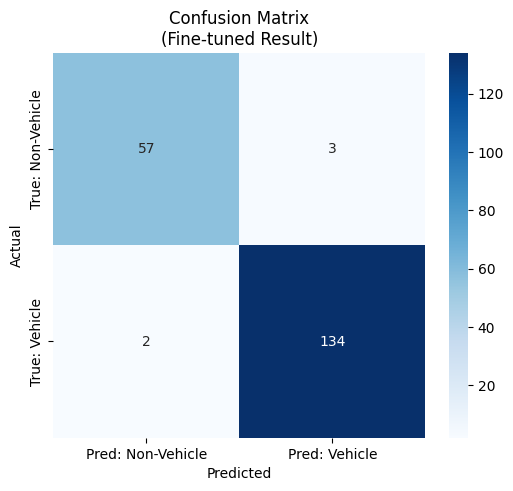


💾 전체 실행 결과 저장 완료!
   -> 파일 경로: /content/drive/MyDrive/03. HDMF/(pre_study)2026_ImageDetectionStudy/1_car_classification/inference_finetuned_test_results.csv
   -> 총 데이터 수: 196건
   -> (성공: 191건, 실패: 5건)


In [3]:
# [Cell 4] Fine-tuned Model Test Set 평가 (경로 수정됨)
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from ultralytics import YOLO
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tqdm import tqdm

# =========================================================
# [설정] 경로 및 파라미터 (User 환경에 맞게 자동 수정됨)
# =========================================================
# 1. 학습된 모델 경로
#    (방금 학습한 결과가 저장된 구글 드라이브 경로)
DATASET_ROOT = "/content/drive/MyDrive/03. HDMF/(pre_study)2026_ImageDetectionStudy/1_car_classification/(dataset)2026_FineTuning_Hybrid_Split_721"
MODEL_PATH = os.path.join(DATASET_ROOT, "train_results/yolov8x_finetuned_vehicle/weights/best.pt")

# 2. 테스트 데이터셋 경로 (Hybrid_Split_721 폴더 내의 test 폴더)
TEST_IMG_DIR = os.path.join(DATASET_ROOT, "images/test")
TEST_LABEL_DIR = os.path.join(DATASET_ROOT, "labels/test")

# 3. 결과 저장 경로
RESULT_ROOT = "/content/drive/MyDrive/03. HDMF/(pre_study)2026_ImageDetectionStudy/1_car_classification"
os.makedirs(RESULT_ROOT, exist_ok=True)

CONF_THRESHOLD = 0.25  # Fine-tuning 했으므로 표준 임계값 사용

def evaluate_finetuned_model():
    if not os.path.exists(MODEL_PATH):
        print(f"❌ 모델 파일이 없습니다: {MODEL_PATH}")
        print("   -> 학습이 정상적으로 완료되었는지 확인해주세요.")
        return

    print(f"🚀 평가 시작...")
    print(f"   - 모델: {MODEL_PATH}")
    print(f"   - 데이터: {TEST_IMG_DIR}")

    model = YOLO(MODEL_PATH)

    # 평가 대상 파일 리스트업
    image_files = [f for f in os.listdir(TEST_IMG_DIR) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]

    if len(image_files) == 0:
        print(f"❌ 테스트 이미지가 없습니다. 경로를 확인해주세요: {TEST_IMG_DIR}")
        return

    results_list = []
    speed_stats = []

    print(f"   - 총 평가 대상: {len(image_files)}장")

    for file in tqdm(image_files, desc="Inference"):
        img_path = os.path.join(TEST_IMG_DIR, file)
        label_path = os.path.join(TEST_LABEL_DIR, os.path.splitext(file)[0] + ".txt")

        # -----------------------------------------------------
        # 1. 정답(True Label) 확인 로직
        # -----------------------------------------------------
        # 라벨 파일이 있고, 내용이 비어있지 않으면 Vehicle(1)
        true_label = 0
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                content = f.read().strip()
                if len(content) > 0:
                    true_label = 1

        # -----------------------------------------------------
        # 2. 모델 추론 (Prediction)
        # -----------------------------------------------------
        results = model(img_path, conf=CONF_THRESHOLD, verbose=False)

        # 속도 측정
        speed_info = results[0].speed
        total_time_ms = speed_info['preprocess'] + speed_info['inference'] + speed_info['postprocess']
        speed_stats.append(total_time_ms)

        # 예측 라벨 결정 (박스가 하나라도 있으면 Vehicle)
        pred_label = 0
        for r in results:
            if len(r.boxes) > 0:
                pred_label = 1
                break

        # 결과 저장
        results_list.append({
            "filename": file,
            "true_label": true_label,
            "pred_label": pred_label,
            "is_correct": (true_label == pred_label),
            "full_path": img_path
        })

    # 데이터프레임 변환
    df = pd.DataFrame(results_list)

    # =========================================================
    # [분석 결과 리포트]
    # =========================================================
    print("\n" + "="*50)
    print("📊 [최종 분석 결과 - Fine-tuned Model]")
    print("="*50)

    # A. 정확도 평가
    acc = accuracy_score(df['true_label'], df['pred_label'])
    print(f"✅ 1. 정확도 (Accuracy): {acc:.4f} ({acc*100:.2f}%)")

    # B. 속도 평가
    if speed_stats:
        avg_time = np.mean(speed_stats)
        min_time = np.min(speed_stats)
        max_time = np.max(speed_stats)
        fps = 1000 / avg_time

        print(f"\n⚡ 2. 추론 속도 (Inference Speed):")
        print(f"   - 평균 소요 시간 : {avg_time:.2f} ms/장")
        print(f"   - 최소 소요 시간 : {min_time:.2f} ms")
        print(f"   - 최대 소요 시간 : {max_time:.2f} ms")
        print(f"   - 처리량 (FPS)   : {fps:.2f} FPS")

    # C. 상세 분류 리포트
    print("\n📝 3. 상세 분류 리포트:")
    print(classification_report(df['true_label'], df['pred_label'], target_names=['Non-Vehicle', 'Vehicle']))

    # D. 혼동 행렬 시각화
    plt.figure(figsize=(6, 5))
    cm = confusion_matrix(df['true_label'], df['pred_label'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Pred: Non-Vehicle', 'Pred: Vehicle'],
                yticklabels=['True: Non-Vehicle', 'True: Vehicle'])
    plt.title(f'Confusion Matrix\n(Fine-tuned Result)')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

    # =========================================================
    # E. 결과 저장
    # =========================================================
    save_filename = f"inference_finetuned_test_results.csv"
    save_path = os.path.join(RESULT_ROOT, save_filename)

    df.to_csv(save_path, index=False, encoding='utf-8-sig')

    print(f"\n💾 전체 실행 결과 저장 완료!")
    print(f"   -> 파일 경로: {save_path}")
    print(f"   -> 총 데이터 수: {len(df)}건")

    failed_count = len(df[df['is_correct'] == False])
    print(f"   -> (성공: {len(df)-failed_count}건, 실패: {failed_count}건)")

# 실행
evaluate_finetuned_model()

In [4]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2
import os
import random
from ultralytics import YOLO

# =========================================================
# [설정] 경로
# =========================================================
# 1. 학습된 최적 모델 경로 (확인 필요)
DATASET_ROOT = "/content/drive/MyDrive/03. HDMF/(pre_study)2026_ImageDetectionStudy/1_car_classification/(dataset)2026_FineTuning_Hybrid_Split_721"
MODEL_PATH = os.path.join(DATASET_ROOT, "train_results/yolov8x_finetuned_vehicle/weights/best.pt")

# 2. 테스트 데이터셋 경로 (Hybrid_Split_721 폴더 내의 test 폴더)
TEST_IMG_DIR = os.path.join(DATASET_ROOT, "images/test")
TEST_LABEL_DIR = os.path.join(DATASET_ROOT, "labels/test")

def visualize_comparison(num_samples=5):
    if not os.path.exists(MODEL_PATH):
        print("❌ 학습된 모델 파일이 없습니다.")
        return

    model = YOLO(MODEL_PATH)
    files = [f for f in os.listdir(TEST_IMG_DIR) if f.lower().endswith(('.jpg', '.png'))]
    random.shuffle(files)

    samples = files[:num_samples]

    plt.figure(figsize=(15, 5 * num_samples))

    for i, file in enumerate(samples):
        img_path = os.path.join(TEST_IMG_DIR, file)
        label_path = os.path.join(TEST_LABEL_DIR, os.path.splitext(file)[0] + ".txt")

        # 이미지 로드
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        h, w, _ = img.shape

        # -------------------------------------------------
        # 1. Ground Truth (초록색) 그리기
        # -------------------------------------------------
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                lines = f.readlines()
                for line in lines:
                    cls, x, y, bw, bh = map(float, line.strip().split())
                    # YOLO xywhn -> pixel xymn (좌상단)
                    x1 = int((x - bw / 2) * w)
                    y1 = int((y - bh / 2) * h)
                    x2 = int((x + bw / 2) * w)
                    y2 = int((y + bh / 2) * h)

                    cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 3) # Green
                    cv2.putText(img, "GT", (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

        # -------------------------------------------------
        # 2. Prediction (빨간색) 그리기
        # -------------------------------------------------
        results = model(img_path, conf=0.1, verbose=False) # Threshold 낮게 설정
        for result in results:
            for box in result.boxes:
                x1, y1, x2, y2 = map(int, box.xyxy[0])
                conf = float(box.conf[0])

                cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 3) # Red
                cv2.putText(img, f"Pred {conf:.2f}", (x1, y2+30), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)

        # 출력
        plt.subplot(num_samples, 1, i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Sample: {file} (Green: GT, Red: Prediction)", fontsize=14)

    plt.tight_layout()
    plt.show()


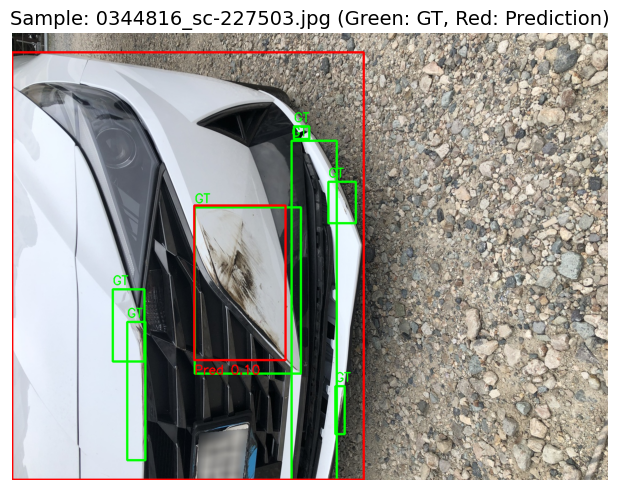

In [11]:
# 실행
visualize_comparison(1)

🚀 평가 시작...
   - 모델: /content/drive/MyDrive/03. HDMF/(pre_study)2026_ImageDetectionStudy/1_car_classification/(dataset)2026_FineTuning_Hybrid_Split_721/train_results/yolov8x_finetuned_vehicle/weights/best.pt
   - 데이터: /content/drive/MyDrive/03. HDMF/(pre_study)2026_ImageDetectionStudy/1_car_classification/images/test
   - 총 평가 대상: 196장


Inference: 100%|██████████| 196/196 [04:05<00:00,  1.25s/it]



📊 [최종 분석 결과 - Fine-tuned Model]
✅ 1. 정확도 (Accuracy): 0.9745 (97.45%)

⚡ 2. 추론 속도 (Inference Speed):
   - 평균 소요 시간 : 16.54 ms/장
   - 최소 소요 시간 : 11.77 ms
   - 최대 소요 시간 : 70.77 ms
   - 처리량 (FPS)   : 60.47 FPS

📝 3. 상세 분류 리포트:
              precision    recall  f1-score   support

 Non-Vehicle       0.94      0.98      0.96        61
     Vehicle       0.99      0.97      0.98       135

    accuracy                           0.97       196
   macro avg       0.96      0.98      0.97       196
weighted avg       0.98      0.97      0.97       196



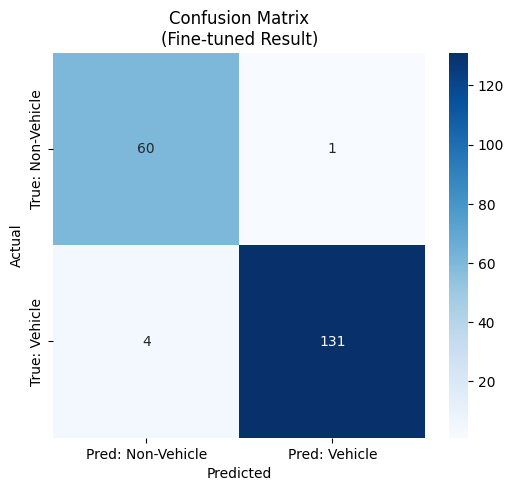


💾 전체 실행 결과 저장 완료!
   -> 파일 경로: /content/drive/MyDrive/03. HDMF/(pre_study)2026_ImageDetectionStudy/1_car_classification/inference_finetuned_test_results.csv
   -> 총 데이터 수: 196건
   -> (성공: 191건, 실패: 5건)


In [7]:
# [Cell 4] Fine-tuned Model Test Set 평가 (경로 수정됨)
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from ultralytics import YOLO
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tqdm import tqdm

# =========================================================
# [설정] 경로 및 파라미터 (User 환경에 맞게 자동 수정됨)
# =========================================================
# 1. 학습된 모델 경로
#    (방금 학습한 결과가 저장된 구글 드라이브 경로)
DATASET_ROOT = "/content/drive/MyDrive/03. HDMF/(pre_study)2026_ImageDetectionStudy/1_car_classification/(dataset)2026_FineTuning_Hybrid_Split_721"
MODEL_PATH = os.path.join(DATASET_ROOT, "train_results/yolov8x_finetuned_vehicle/weights/best.pt")

# 2. 테스트 데이터셋 경로 (Hybrid_Split_721 폴더 내의 test 폴더)
TEST_IMG_DIR = "/content/drive/MyDrive/03. HDMF/(pre_study)2026_ImageDetectionStudy/1_car_classification/images/test"
TEST_LABEL_DIR = "/content/drive/MyDrive/03. HDMF/(pre_study)2026_ImageDetectionStudy/1_car_classification/labels/test"

# 3. 결과 저장 경로
RESULT_ROOT = "/content/drive/MyDrive/03. HDMF/(pre_study)2026_ImageDetectionStudy/1_car_classification"
os.makedirs(RESULT_ROOT, exist_ok=True)

CONF_THRESHOLD = 0.25  # Fine-tuning 했으므로 표준 임계값 사용

def evaluate_finetuned_model():
    if not os.path.exists(MODEL_PATH):
        print(f"❌ 모델 파일이 없습니다: {MODEL_PATH}")
        print("   -> 학습이 정상적으로 완료되었는지 확인해주세요.")
        return

    print(f"🚀 평가 시작...")
    print(f"   - 모델: {MODEL_PATH}")
    print(f"   - 데이터: {TEST_IMG_DIR}")

    model = YOLO(MODEL_PATH)

    # 평가 대상 파일 리스트업
    image_files = [f for f in os.listdir(TEST_IMG_DIR) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]

    if len(image_files) == 0:
        print(f"❌ 테스트 이미지가 없습니다. 경로를 확인해주세요: {TEST_IMG_DIR}")
        return

    results_list = []
    speed_stats = []

    print(f"   - 총 평가 대상: {len(image_files)}장")

    for file in tqdm(image_files, desc="Inference"):
        img_path = os.path.join(TEST_IMG_DIR, file)
        label_path = os.path.join(TEST_LABEL_DIR, os.path.splitext(file)[0] + ".txt")

        # -----------------------------------------------------
        # 1. 정답(True Label) 확인 로직
        # -----------------------------------------------------
        # 라벨 파일이 있고, 내용이 비어있지 않으면 Vehicle(1)
        true_label = 0
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                content = f.read().strip()
                if len(content) > 0:
                    true_label = 1

        # -----------------------------------------------------
        # 2. 모델 추론 (Prediction)
        # -----------------------------------------------------
        results = model(img_path, conf=CONF_THRESHOLD, verbose=False)

        # 속도 측정
        speed_info = results[0].speed
        total_time_ms = speed_info['preprocess'] + speed_info['inference'] + speed_info['postprocess']
        speed_stats.append(total_time_ms)

        # 예측 라벨 결정 (박스가 하나라도 있으면 Vehicle)
        pred_label = 0
        for r in results:
            if len(r.boxes) > 0:
                pred_label = 1
                break

        # 결과 저장
        results_list.append({
            "filename": file,
            "true_label": true_label,
            "pred_label": pred_label,
            "is_correct": (true_label == pred_label),
            "full_path": img_path
        })

    # 데이터프레임 변환
    df = pd.DataFrame(results_list)

    # =========================================================
    # [분석 결과 리포트]
    # =========================================================
    print("\n" + "="*50)
    print("📊 [최종 분석 결과 - Fine-tuned Model]")
    print("="*50)

    # A. 정확도 평가
    acc = accuracy_score(df['true_label'], df['pred_label'])
    print(f"✅ 1. 정확도 (Accuracy): {acc:.4f} ({acc*100:.2f}%)")

    # B. 속도 평가
    if speed_stats:
        avg_time = np.mean(speed_stats)
        min_time = np.min(speed_stats)
        max_time = np.max(speed_stats)
        fps = 1000 / avg_time

        print(f"\n⚡ 2. 추론 속도 (Inference Speed):")
        print(f"   - 평균 소요 시간 : {avg_time:.2f} ms/장")
        print(f"   - 최소 소요 시간 : {min_time:.2f} ms")
        print(f"   - 최대 소요 시간 : {max_time:.2f} ms")
        print(f"   - 처리량 (FPS)   : {fps:.2f} FPS")

    # C. 상세 분류 리포트
    print("\n📝 3. 상세 분류 리포트:")
    print(classification_report(df['true_label'], df['pred_label'], target_names=['Non-Vehicle', 'Vehicle']))

    # D. 혼동 행렬 시각화
    plt.figure(figsize=(6, 5))
    cm = confusion_matrix(df['true_label'], df['pred_label'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Pred: Non-Vehicle', 'Pred: Vehicle'],
                yticklabels=['True: Non-Vehicle', 'True: Vehicle'])
    plt.title(f'Confusion Matrix\n(Fine-tuned Result)')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

    # =========================================================
    # E. 결과 저장
    # =========================================================
    save_filename = f"inference_finetuned_test_results.csv"
    save_path = os.path.join(RESULT_ROOT, save_filename)

    df.to_csv(save_path, index=False, encoding='utf-8-sig')

    print(f"\n💾 전체 실행 결과 저장 완료!")
    print(f"   -> 파일 경로: {save_path}")
    print(f"   -> 총 데이터 수: {len(df)}건")

    failed_count = len(df[df['is_correct'] == False])
    print(f"   -> (성공: {len(df)-failed_count}건, 실패: {failed_count}건)")

# 실행
evaluate_finetuned_model()